### Problem Statment 
* our task is to predict the price of a book given some attributes

### Columns Description

* `ID` - Identifier <br>
* `Title` - Title of the book <br>
* `Author`- name of the author <br>
* `Edition`- edition of the book <br>
* `Reviews`- Average stars <br>
* `Ratings` - number of people who reviewed the book <br> 
* `Synopsis` - Synopsis of the book <br>
* `Genre` - Genre of the book <br>
* `BookCategory`- Category of the Book <br>
* `Price` - Target col price of the book <br>

### Environment Set-up

In [787]:
# importing the needed packages

import pandas as pd
import numpy as np

import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import re
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
from sklearn.model_selection import cross_val_score

In [788]:
# ignoring warnings
import warnings
warnings.filterwarnings('ignore')

In [789]:
# Reading our datasets

training_data = pd.read_csv('train_dataset.csv')

test_data = pd.read_csv('test_dataset.csv')

### Taking a quick look at the data structure

In [790]:
training_data.head()

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
0,Jesse James (Lucky Luke),"Rene Goscinny, Jean Tarbary","Paperback,– Import, 1 Apr 2008",5.0 out of 5 stars,1 customer review,Cowboy Lucky Luke upholds the law of the Wild ...,Comics & Mangas (Books),Comics & Mangas,2.292
1,A Storm of Swords 2: Blood and Gold (A Song of...,George R. R. Martin,"Paperback,– 27 Mar 2014",4.5 out of 5 stars,474 customer reviews,HBO’s hit series A GAME OF THRONES is based on...,Action & Adventure (Books),"Crime, Thriller & Mystery",4.800
2,"Mastering Copperplate Calligraphy (Lettering, ...",Eleanor Winters,"Paperback,– 28 May 2000",4.9 out of 5 stars,15 customer reviews,Developed by English handwriting masters in th...,"Handicrafts, Decorative Arts & Crafts (Books)","Arts, Film & Photography",10.500
3,I Am Zlatan Ibrahimovic,Zlatan Ibrahimovic,"Paperback,– 24 Sep 2013",4.8 out of 5 stars,52 customer reviews,"I AM ZLATAN - the explosive, critically-acclai...",Biographies & Autobiographies (Books),Sports,5.520
4,Bought For The Billionaire's Revenge (Modern),Connelly Clare,"Paperback,– 28 Jul 2017",4.5 out of 5 stars,2 customer reviews,Sold to the ruthless tycoon!\n\nInnocent socia...,Romance (Books),Romance,4.776


In [791]:
training_data.shape

(6823, 9)

In [792]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6823 entries, 0 to 6822
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Title         6822 non-null   object 
 1   Author        6822 non-null   object 
 2   Edition       6823 non-null   object 
 3   Reviews       6823 non-null   object 
 4   Ratings       6823 non-null   object 
 5   Synopsis      5808 non-null   object 
 6   Genre         6822 non-null   object 
 7   BookCategory  6419 non-null   object 
 8   Price         6823 non-null   float64
dtypes: float64(1), object(8)
memory usage: 479.9+ KB


In [793]:
training_data.duplicated().sum()

205

In [794]:
training_data.isna().sum()

Title              1
Author             1
Edition            0
Reviews            0
Ratings            0
Synopsis        1015
Genre              1
BookCategory     404
Price              0
dtype: int64

### splitting the data

In [795]:
x= training_data.drop('Price', axis=1)
y= training_data[['Price']]

x_train, x_val, y_train, y_val= train_test_split(x, y, test_size=0.2, random_state=42)


In [796]:
x_train.head()

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory
2115,The Queen of Nothing (The Folk of the Air #3),Holly Black,"Nov 19, 2019",5.0 out of 5 stars,11 customer reviews,The intoxicating and bloodthirsty finale to th...,"Young Adult Fiction , Fantasy , Dark Fantasy",Fantasy
2392,Destiny Unpredictable,Simmi Chauhan,"Paperback,– Import, 27 May 2019",5.0 out of 5 stars,1 customer review,We all know that the journey of life is unpred...,Romance (Books),Romance
2318,Good Night Stories for Rebel Girls 2,Francesca Cavallo,"Hardcover,– 10 Sep 2018",4.2 out of 5 stars,30 customer reviews,"100 new bedtime stories, each inspired by the ...",Children's Reference (Books),"Biographies, Diaries & True Accounts"
5377,Artificial Intelligence with Python,Prateek Joshi,"Paperback,– Import, 27 Jan 2017",3.5 out of 5 stars,6 customer reviews,Build real-world Artificial Intelligence appli...,Algorithms,"Computing, Internet & Digital Media"
2298,Bowden/assassin's Creed Unity,Oliver Bowden,"Paperback,– 25 Nov 2014",4.8 out of 5 stars,19 customer reviews,Assassin's Creed: Unity is the seventh title i...,Action & Adventure (Books),"Crime, Thriller & Mystery"


In [797]:
y_train.head()

,Price
2115,36.860
2392,2.988
2318,6.720
5377,15.588
2298,3.240


### creating a training set

* I would try my cleaning on the training set without seeing the validation set so I can use a pipeline on both of them

In [798]:
training_set = pd.concat([x_train,y_train],axis=1).reset_index(drop=True)
training_set.head()

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
0,The Queen of Nothing (The Folk of the Air #3),Holly Black,"Nov 19, 2019",5.0 out of 5 stars,11 customer reviews,The intoxicating and bloodthirsty finale to th...,"Young Adult Fiction , Fantasy , Dark Fantasy",Fantasy,36.860
1,Destiny Unpredictable,Simmi Chauhan,"Paperback,– Import, 27 May 2019",5.0 out of 5 stars,1 customer review,We all know that the journey of life is unpred...,Romance (Books),Romance,2.988
2,Good Night Stories for Rebel Girls 2,Francesca Cavallo,"Hardcover,– 10 Sep 2018",4.2 out of 5 stars,30 customer reviews,"100 new bedtime stories, each inspired by the ...",Children's Reference (Books),"Biographies, Diaries & True Accounts",6.720
3,Artificial Intelligence with Python,Prateek Joshi,"Paperback,– Import, 27 Jan 2017",3.5 out of 5 stars,6 customer reviews,Build real-world Artificial Intelligence appli...,Algorithms,"Computing, Internet & Digital Media",15.588
4,Bowden/assassin's Creed Unity,Oliver Bowden,"Paperback,– 25 Nov 2014",4.8 out of 5 stars,19 customer reviews,Assassin's Creed: Unity is the seventh title i...,Action & Adventure (Books),"Crime, Thriller & Mystery",3.240


###### handeling the `Reviews` column

* we would extract the first 3 characters which represent the average stars

In [799]:
training_set['Reviews']= training_set['Reviews'].str.split(' ').str.get(0)

training_set['Reviews'].unique()

array(['5.0', '4.2', '3.5', '4.8', '4.0', '3.8', '3.7', '3.6', '4.7',
       '3.9', '4.4', '4.5', '4.1', '4.6', '4.3', '3.0', '4.9', '2.5',
       '2.9', '1.0', 'nan', '3.3', '2.7', '3.1', '3.4', '3.2', '2.2',
       '1.4', '2.4', '2.3', '2.6', '2.0', '1.5', '2.8'], dtype=object)

In [800]:
training_set['Reviews']= pd.to_numeric(training_set['Reviews'], errors = 'coerce')

###### handeling the `Ratings` column

* like before we would just extract the numeric part which represents the number of people reviewed the movie

In [801]:
training_set['Ratings']= training_set['Ratings'].str.extract('(\d+)').astype(float)

training_set.head()

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
0,The Queen of Nothing (The Folk of the Air #3),Holly Black,"Nov 19, 2019",5.0,11.0,The intoxicating and bloodthirsty finale to th...,"Young Adult Fiction , Fantasy , Dark Fantasy",Fantasy,36.860
1,Destiny Unpredictable,Simmi Chauhan,"Paperback,– Import, 27 May 2019",5.0,1.0,We all know that the journey of life is unpred...,Romance (Books),Romance,2.988
2,Good Night Stories for Rebel Girls 2,Francesca Cavallo,"Hardcover,– 10 Sep 2018",4.2,30.0,"100 new bedtime stories, each inspired by the ...",Children's Reference (Books),"Biographies, Diaries & True Accounts",6.720
3,Artificial Intelligence with Python,Prateek Joshi,"Paperback,– Import, 27 Jan 2017",3.5,6.0,Build real-world Artificial Intelligence appli...,Algorithms,"Computing, Internet & Digital Media",15.588
4,Bowden/assassin's Creed Unity,Oliver Bowden,"Paperback,– 25 Nov 2014",4.8,19.0,Assassin's Creed: Unity is the seventh title i...,Action & Adventure (Books),"Crime, Thriller & Mystery",3.240


###### handeling the `Edition` column

* first, we would extract the year the book was released in
* seconed, we would make a feature `Imported` where the imported books take 1, while other books take 0
* lasly, we would make a feature `Cover` where we would hold the cover's type

1. making the `year` column

In [802]:
training_set['Year']= training_set['Edition'].str[-4:]

training_set['Year']= pd.to_numeric(training_set['Year'], errors = 'coerce')

2. making the `cover` column

In [803]:
training_set['Cover']= training_set['Edition'].str.split(',–').str.get(0)

training_set['Cover'].value_counts().head(10)

Paperback                3227
Hardcover                 503
Mass Market Paperback      99
Hardcover,- 2012           40
Hardcover,- 2013           39
Hardcover,- 2010           36
Hardcover,- 2009           35
Hardcover,- 2011           34
Hardcover,- 2020           33
Hardcover,- 2018           33
Name: Cover, dtype: int64

In [804]:
training_set['Cover']= training_set['Cover'].str.split(',-').str.get(0)

In [805]:
training_set['Cover'].value_counts().head(12)

Paperback                3545
Hardcover                 912
Mass Market Paperback     115
Board book                 44
Oct 15, 2019               33
Oct 17, 2019               21
Oct 29, 2019               19
Sheet music                17
Nov 5, 2019                13
Nov 19, 2019               12
Oct 14, 2010               10
Flexibound                  9
Name: Cover, dtype: int64

In [806]:
categories=['Paperback', 'Hardcover', 'Mass Market Paperback', 'Board book', 'Sheet music', 'Flexibound']

training_set.Cover[~training_set['Cover'].isin(categories)]= np.nan

training_set['Cover'].value_counts(dropna= False).head()

Paperback                3545
Hardcover                 912
NaN                       816
Mass Market Paperback     115
Board book                 44
Name: Cover, dtype: int64

3. making the imported column

training_set['Imported']= training_set['Edition'].str.split(',–').str.get(1).str.split(',').str.get(0)

training_set['Imported'].value_counts()[0:5]

training_set['Imported'].replace({'Import': '1'}, inplace=True)

training_set.loc[training_set['Imported'] != 1, 'Imported']= 0

training_set['Imported'].value_counts()

In [807]:
training_set.head()

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price,Year,Cover
0,The Queen of Nothing (The Folk of the Air #3),Holly Black,"Nov 19, 2019",5.0,11.0,The intoxicating and bloodthirsty finale to th...,"Young Adult Fiction , Fantasy , Dark Fantasy",Fantasy,36.860,2019.0,NaN
1,Destiny Unpredictable,Simmi Chauhan,"Paperback,– Import, 27 May 2019",5.0,1.0,We all know that the journey of life is unpred...,Romance (Books),Romance,2.988,2019.0,Paperback
2,Good Night Stories for Rebel Girls 2,Francesca Cavallo,"Hardcover,– 10 Sep 2018",4.2,30.0,"100 new bedtime stories, each inspired by the ...",Children's Reference (Books),"Biographies, Diaries & True Accounts",6.720,2018.0,Hardcover
3,Artificial Intelligence with Python,Prateek Joshi,"Paperback,– Import, 27 Jan 2017",3.5,6.0,Build real-world Artificial Intelligence appli...,Algorithms,"Computing, Internet & Digital Media",15.588,2017.0,Paperback
4,Bowden/assassin's Creed Unity,Oliver Bowden,"Paperback,– 25 Nov 2014",4.8,19.0,Assassin's Creed: Unity is the seventh title i...,Action & Adventure (Books),"Crime, Thriller & Mystery",3.240,2014.0,Paperback


* with fixing that up we can now dig deeper into the numerical columns

In [808]:
training_set.describe()

,Reviews,Ratings,Price,Year
count,5410.000000,5410.000000,5458.000000,5444.000000
mean,4.369316,3787.646396,13.551192,2012.021492
std,0.588056,14818.304803,26.657827,35.690291
min,1.000000,1.000000,0.000000,186.000000
25%,4.100000,3.000000,3.588000,2010.750000
50%,4.500000,11.000000,5.784000,2015.000000
75%,4.800000,80.000000,13.390000,2017.000000
max,5.000000,344811.000000,886.080000,2021.000000


the data isn't just skewed, it has unreasonable values like:

* the minimum of the year column is 186 and that doesn't make any sense.
* the maximum value of the price column 886 and the minimum is 0 

In [809]:
training_set['Year'].sort_values()[0:5]

2846     186.0
792      186.0
1481    1900.0
3962    1960.0
2456    1961.0
Name: Year, dtype: float64

* they are just two values which maybe refer 1986 so I would fix it manually

In [810]:
training_set.Year[training_set['Year']==186] = 1986

* now lets look at the distributions of these columns

In [811]:
from matplotlib import rcParams            
rcParams['figure.figsize'] = (30,7) 

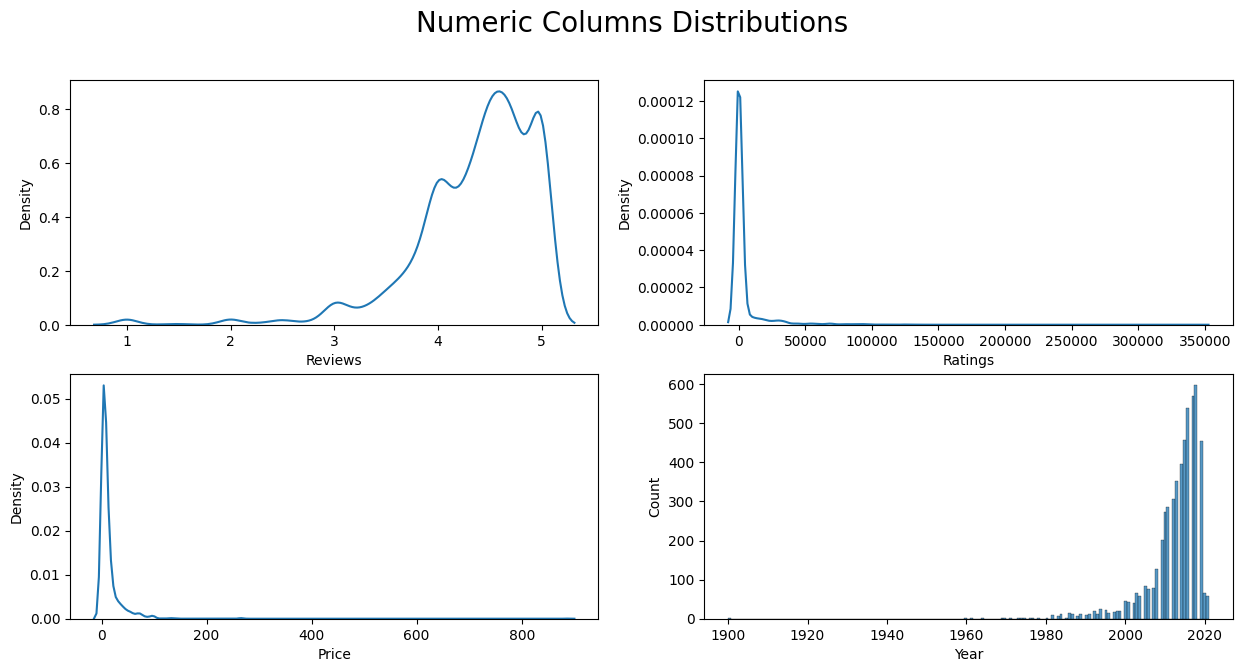

In [812]:
fig, ax = plt.subplots(2,2, figsize=(15,7))

sns.kdeplot(x= 'Reviews', data=training_set, ax=ax[0,0])
sns.kdeplot(x= 'Ratings', data=training_set, ax=ax[0,1])
sns.kdeplot(x= 'Price', data=training_set, ax=ax[1,0])
sns.histplot(x= 'Year', data=training_set, ax=ax[1,1])
plt. suptitle('Numeric Columns Distributions',fontsize= 20 )
plt.show()

* the data is very skewed which means it need transformation and would be median

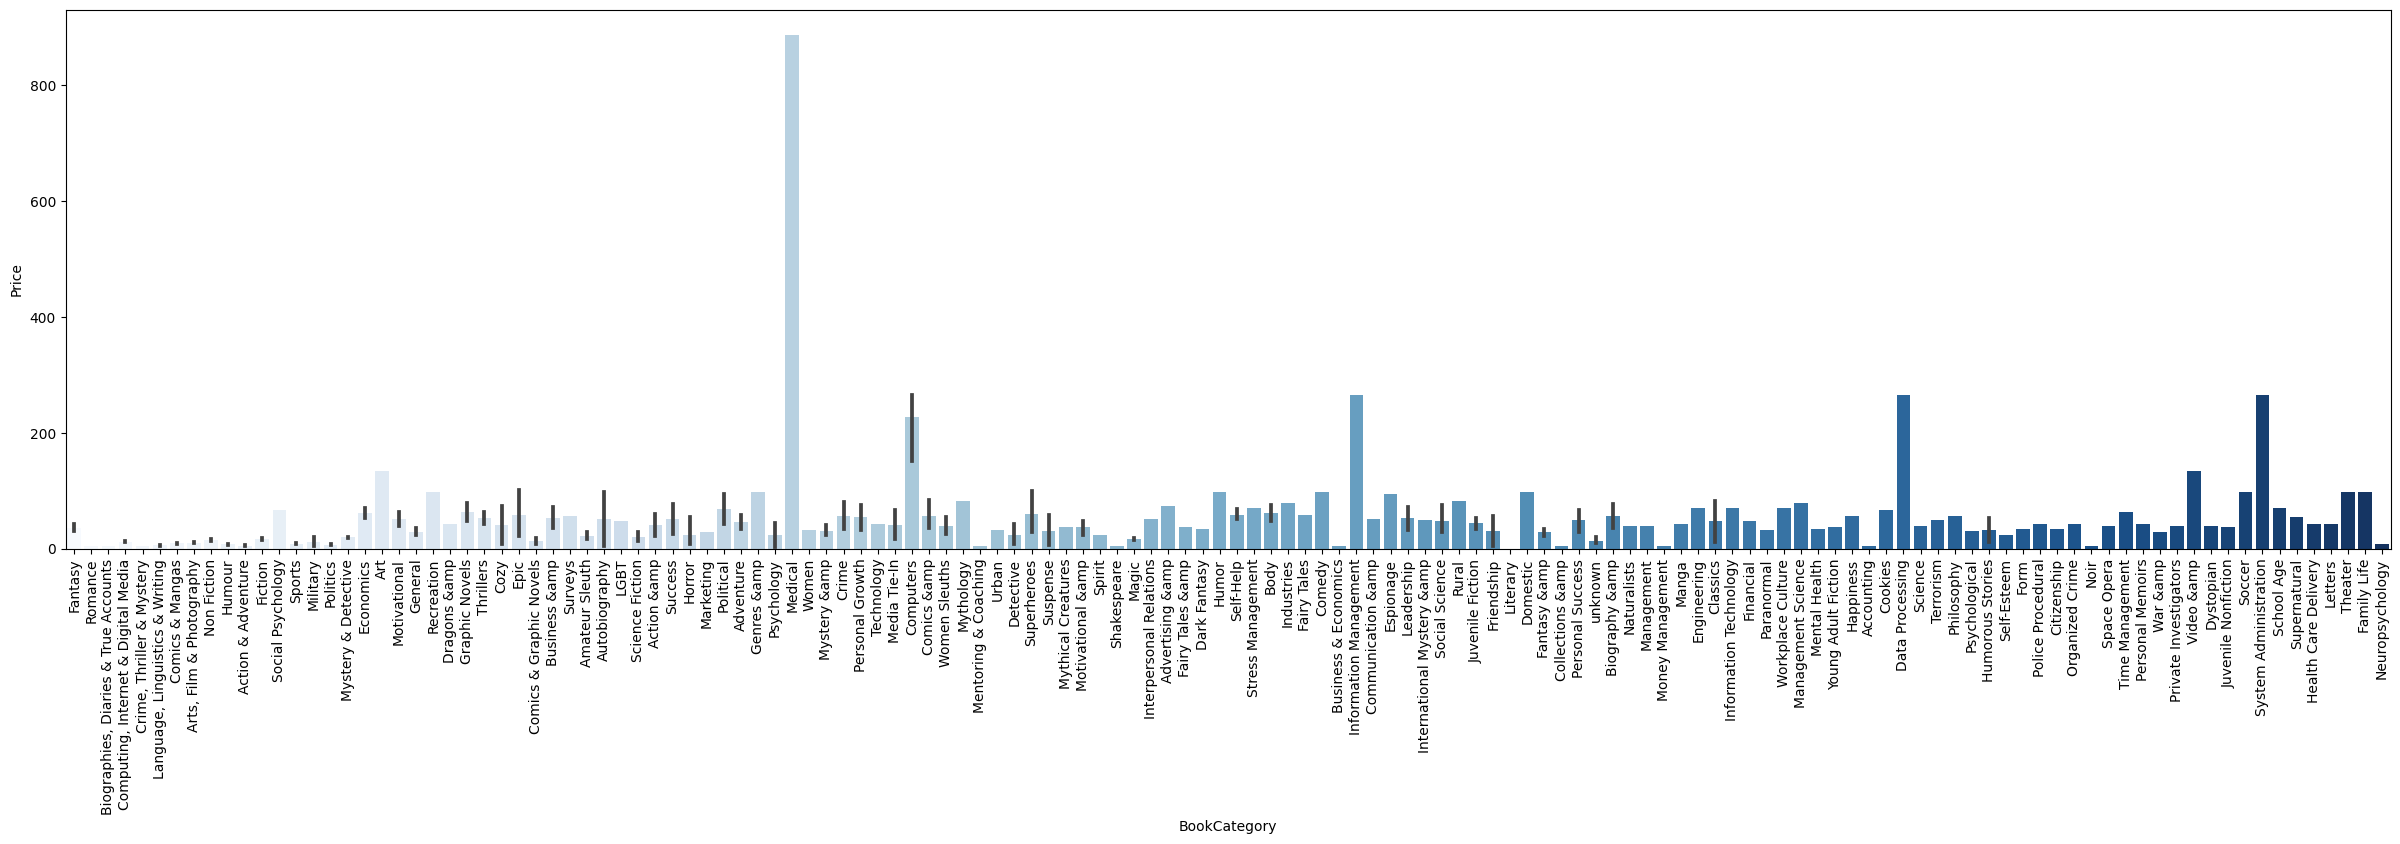

In [813]:
sns.barplot(x= 'BookCategory', y='Price', data= training_set, palette= 'Blues')
plt.xticks(rotation=90)
plt.show()

In [814]:
training_set[training_set['BookCategory']== 'Medical']

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price,Year,Cover
487,Tintinalli's Emergency Medicine: A Comprehensi...,Judith E. Tintinalli,"Oct 22, 2019",NaN,NaN,Publisher's Note: Products purchased from Thir...,"Medical , Internal Medicine",Medical,886.08,2019.0,NaN


<Axes: xlabel='Price', ylabel='Density'>

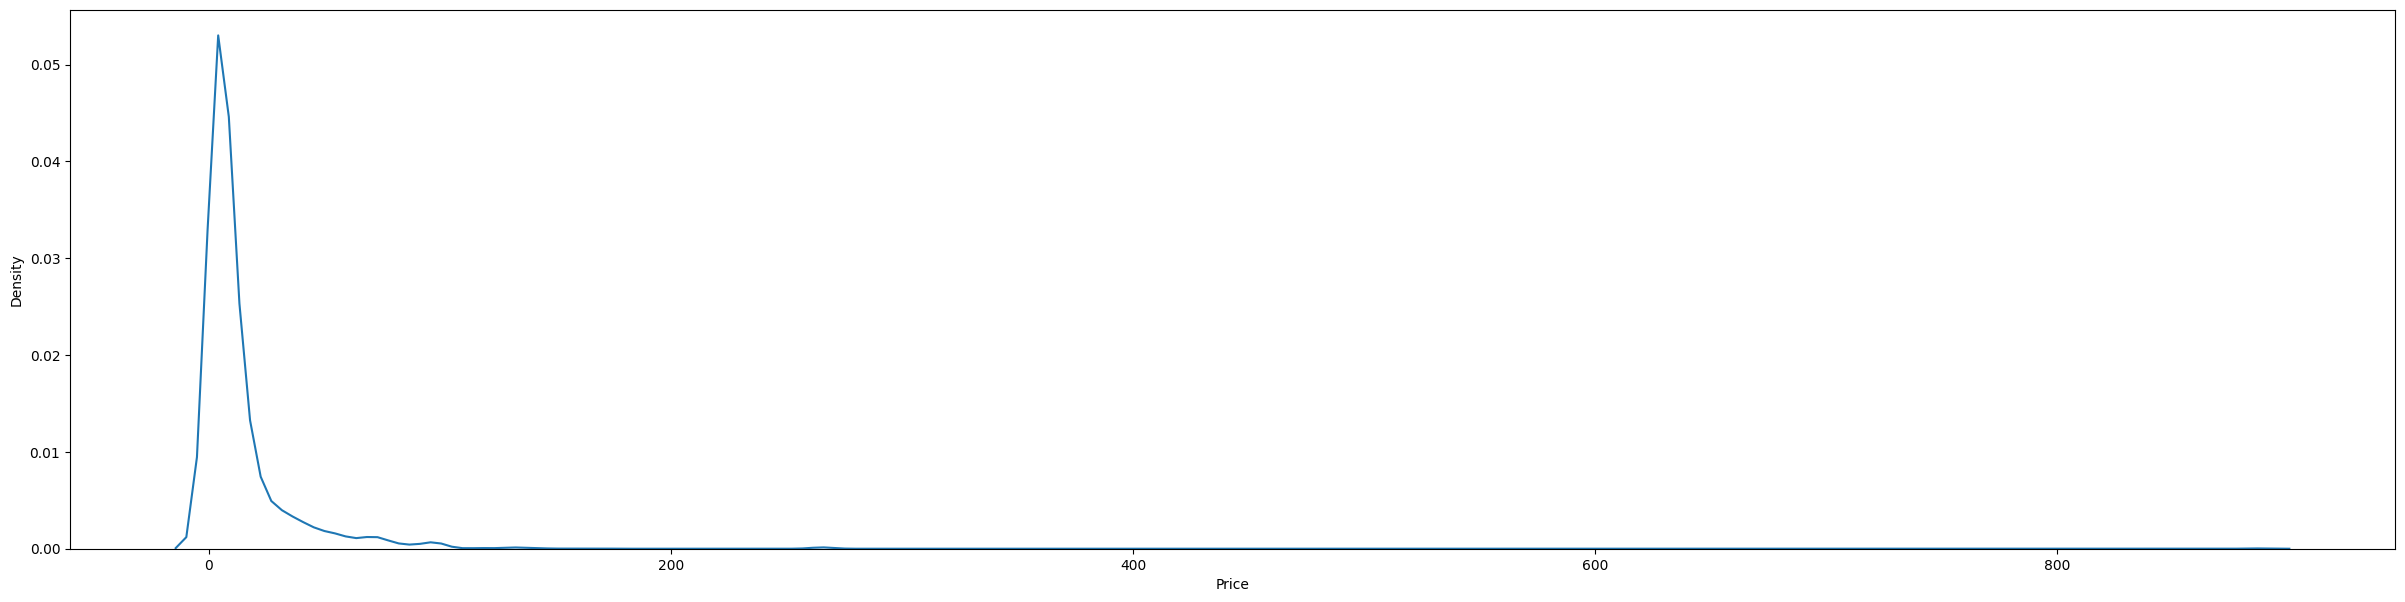

In [815]:
sns.kdeplot(x='Price', data=training_set)

In [816]:
class ColumnSelector(TransformerMixin, BaseEstimator):
    """
    Transformer that selects only the specified columns from a data frame.

    Parameters:
    ----------
    columns : list or array-like, default=None
        List of column names to select from the input data frame. If None, all columns are selected.
    """
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        X = X[self.columns]
        return X
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [817]:
# Custom transformer to apply log transform to specified columns
class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_log = X.copy()
        for col in self.columns:
            X_log[col] = np.log1p(X_log[col])  # Apply log transform (using np.log1p to handle zero values)
        return X_log

In [818]:
# transformer to replace each category with its count
class CategoryCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.column_names = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        result = X.copy()
        for col in self.column_names:
            result[col] = X[col].map(X[col].value_counts())
        return result

In [819]:
# transformer to extract the numeric part of a column and discard the rest of it    
class StringCleanerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column_names):
            self.column_names = column_names
            
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        cleaned_df = X.copy()
        for col in self.column_names:
            if cleaned_df[col].dtype == object:  # Check if the column contains strings
                cleaned_df[col] = cleaned_df[col].apply(lambda x: re.sub(r'\D', '', str(x)))
                cleaned_df[col] = pd.to_numeric(cleaned_df[col], errors='ignore')
        return cleaned_df

In [820]:
# Custom transformer to extract year numeric value and part of the text from a column
class YearAndTextExtractorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        year_pattern = r'\b(\d{4})\b'  # Add a capture group around the year pattern
        X_new = X.copy()
        X_new['Year'] = X[self.column_name].str.extract(year_pattern).astype(float)
        X_new['Cover'] = X[self.column_name].str.split(',–').str.get(0).str.split(',-').str.get(0)
        categories=['Paperback', 'Hardcover', 'Mass Market Paperback', 'Board book', 'Sheet music', 'Flexibound']
        X_new.Cover[~X_new['Cover'].isin(categories)]= np.nan
        X_new['Age']= 2021- X_new['Year']
        X_new.drop(columns=self.column_name, inplace=True)
        return X_new

In [821]:
# Custom transformer  to impute missing values
class DataFrameImputer(BaseEstimator, TransformerMixin):
    def __init__(self, median_cols=None, mode_cols=None):
        self.median_cols = median_cols
        self.mode_cols = mode_cols

    def fit(self, X, y=None):
        if self.median_cols:
            self.median_values = X[self.median_cols].median()
        if self.mode_cols:
            self.mode_values = X[self.mode_cols].mode().iloc[0]
        return self

    def transform(self, X):
        X_imputed = X.copy()
        if self.median_cols:
            X_imputed[self.median_cols] = X_imputed[self.median_cols].fillna(self.median_values)
        if self.mode_cols:
            X_imputed[self.mode_cols] = X_imputed[self.mode_cols].fillna(self.mode_values)
        return X_imputed


In [822]:
# Custom transformer to drop unuseful columns
class DropColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.columns)
    

In [823]:
# Custom transformer to handle outliers
class WinsorizationImpute(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, outlier_handling='truncate', p=0, q=0.95):
        self.columns = columns
        self.outlier_handling = outlier_handling
        self.p = p
        self.q = q

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_winsorized = X.copy()
        for col in self.columns:
            lower_bound = X_winsorized[col].quantile(self.p)
            upper_bound = X_winsorized[col].quantile(self.q)
            if self.outlier_handling == 'truncate':
                X_winsorized[col] = X_winsorized[col].clip(lower_bound, upper_bound)
            elif self.outlier_handling == 'random_in_distribution':
                outliers_low = X_winsorized[col] < lower_bound
                outliers_high = X_winsorized[col] > upper_bound
                X_winsorized[col] = X_winsorized[col].where(~(outliers_low | outliers_high),
                                                          np.random.uniform(lower_bound, upper_bound))
        return X_winsorized

In [824]:
# Custom transformer to scale the features using standard scaler 
class ColumnSelectorAndScaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns])
        return self

    def transform(self, X):
        X_scaled = X.copy()
        X_scaled[self.columns] = self.scaler.transform(X[self.columns])
        return X_scaled
    

In [825]:
class OneHotEncodeColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.encoder_ = None

    def fit(self, X, y=None):
        self.encoder_ = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        self.encoder_.fit(X.loc[:, self.columns])
        return self

    def transform(self, X):
        X_encoded = pd.DataFrame(self.encoder_.transform(X.loc[:, self.columns]), 
                                 index=X.index)
        X_copy = X.drop(columns=self.columns)
        return pd.concat([X_copy, X_encoded], axis=1)

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)


In [826]:
# FullPipeline1 class
class FullPipeline1:
    def __init__(self):
        # Define the columns for different steps of the pipeline
        self.x_cols = ['Title', 'Author', 'Edition', 'Reviews', 'Ratings', 'Synopsis', 'Genre', 'BookCategory']
        self.median = ['Reviews','Ratings','Year', 'Age' ]
        self.freq = ['Cover', 'Genre', 'BookCategory']
        self.scaling = ['Reviews','Ratings','Year', 'Age']
        self.drop= ['Title', 'Author','Synopsis','Genre','BookCategory']
        self.outlier= ['Reviews','Ratings','Year','Age']
        self.transform= ['Reviews','Ratings','Year', 'Age']
        self.numeric= ['Ratings', 'Reviews']
    
        # Create individual transformers for each step of the pipeline
        self.x_pipeline = Pipeline([
            ('selector', ColumnSelector(self.x_cols)), ## done
            ('category_counter', CategoryCounterTransformer(columns=['BookCategory', 'Genre'])), ## error here !!
            ('numeric_extractor', StringCleanerTransformer( column_names= self.numeric)),  ## done
            ('year_and_text_extractor', YearAndTextExtractorTransformer(column_name='Edition')),  ## done
            ('imputer', DataFrameImputer(median_cols=self.median,  mode_cols= self.freq)), 
            ('drop_cols', DropColumnsTransformer(columns=self.drop)),  ## done
            ('winsorization', WinsorizationImpute(columns=self.outlier, outlier_handling='random_in_distribution',
                                                p=0, q=0.95)),   ## done
            ('log_transformer', LogTransformer(columns=self.transform)),  ## done
            ('scale', ColumnSelectorAndScaler(self.scaling)),  ## done
            ('OneHotEncodeColumns', OneHotEncodeColumns(columns=['Cover'])),

        ])

    def fit_transform(self, X_train):
        X_train = self.x_pipeline.fit_transform(X_train)
        return X_train

    def transform1(self, X_test):
        X_test = self.x_pipeline.transform(X_test)
        return X_test

In [827]:
full_pipeline = FullPipeline1()

x_train = full_pipeline.fit_transform(x_train)

In [828]:
x_train.columns = x_train.columns.astype(str)

In [829]:
x_train.head()

,Reviews,Ratings,Year,Age,0,1,2,3,4,5
2115,0.420350,-0.401941,0.909558,-1.513975,0.0,0.0,0.0,0.0,1.0,0.0
2392,0.420350,-0.923180,0.909558,-1.513975,0.0,0.0,0.0,0.0,1.0,0.0
2318,0.024544,-0.125845,0.780285,-0.998273,0.0,0.0,1.0,0.0,0.0,0.0
5377,-0.388307,-0.558740,0.650949,-0.598264,0.0,0.0,0.0,0.0,1.0,0.0
2298,0.327600,-0.253337,0.262555,0.244269,0.0,0.0,0.0,0.0,1.0,0.0


In [830]:
x_val = full_pipeline.transform1(x_val)

In [831]:
x_val.columns = x_val.columns.astype(str)

In [832]:
x_val.head()

,Reviews,Ratings,Year,Age,0,1,2,3,4,5
101,-0.453835,-0.519894,0.521548,-0.271433,0.0,0.0,0.0,0.0,1.0,0.0
5428,-0.202230,0.030171,0.392083,0.004899,0.0,0.0,0.0,0.0,1.0,0.0
1747,0.077908,-0.603583,-1.166522,1.794871,0.0,0.0,0.0,0.0,1.0,0.0
1670,0.130063,-0.805226,-0.256205,0.971109,0.0,0.0,1.0,0.0,0.0,0.0
1183,-9.779169,-0.357097,0.262555,0.244269,0.0,0.0,0.0,0.0,1.0,0.0


### Logistic Regression

In [833]:
from sklearn.linear_model import LinearRegression

regr = LinearRegression()

regr.fit(x_train, y_train)
train_score = regr.predict(x_train)
print("MAE on training set:", mean_absolute_error(y_train, train_score))

cv_scores = cross_val_score(regr, x_train, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_mae = -1 * cv_scores.mean()
print("MAE on cross-validation set:", cv_mae)

val_pred = regr.predict(x_val)
val_mae = mean_absolute_error(val_pred, y_val)
print("MAE on test set:", val_mae)

MAE on training set: 12.079113735543952
MAE on cross-validation set: 12.09252808295226
MAE on test set: 11.264759587904798


#### RandomForestRegressor

In [834]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 300, max_features = 'sqrt', max_depth = 5, random_state = 18)
rf.fit(x_train, y_train)
train_score = rf.predict(x_train)
print("MAE on training set:", mean_absolute_error(y_train, train_score))


cv_scores = cross_val_score(rf, x_train, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_mae = -1 * cv_scores.mean()
print("MAE on cross-validation set:", cv_mae)

val_pred = rf.predict(x_val)
val_mae = mean_absolute_error(val_pred, y_val)
print("MAE on test set:", val_mae)

MAE on training set: 10.406100203566085


MAE on cross-validation set: 10.588653227334186
MAE on test set: 9.916720417653625


#### XGB

In [835]:
from xgboost import XGBRegressor

XGB = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

XGB.fit(x_train, y_train)

val_pred = XGB.predict(x_val)

mean_absolute_error(y_val, val_pred)



6.741480016568843

#### CatBoost

In [836]:
import catboost as cb

model = cb.CatBoostRegressor()

model.fit(x_train, y_train)

val_pred = model.predict(x_val)

mean_absolute_error(y_val, val_pred)

Learning rate set to 0.053534
0:	learn: 26.3720611	total: 3.18ms	remaining: 3.18s
1:	learn: 26.1043542	total: 6.21ms	remaining: 3.1s
2:	learn: 25.8603215	total: 9.39ms	remaining: 3.12s
3:	learn: 25.7360839	total: 12.2ms	remaining: 3.04s
4:	learn: 25.5120422	total: 15.3ms	remaining: 3.04s
5:	learn: 25.3289333	total: 18.2ms	remaining: 3.02s
6:	learn: 25.2301910	total: 21.6ms	remaining: 3.06s
7:	learn: 25.0564846	total: 24.6ms	remaining: 3.04s
8:	learn: 24.8864082	total: 27.1ms	remaining: 2.98s
9:	learn: 24.7444326	total: 29.8ms	remaining: 2.95s
10:	learn: 24.6535295	total: 32.5ms	remaining: 2.92s
11:	learn: 24.5780087	total: 35.2ms	remaining: 2.9s
12:	learn: 24.4451325	total: 38.2ms	remaining: 2.9s
13:	learn: 24.3228379	total: 40.7ms	remaining: 2.87s
14:	learn: 24.2076486	total: 43.4ms	remaining: 2.85s
15:	learn: 24.1065638	total: 45.9ms	remaining: 2.82s
16:	learn: 24.0235104	total: 48.7ms	remaining: 2.82s
17:	learn: 23.9715934	total: 51.5ms	remaining: 2.81s
18:	learn: 23.8837995	total: 

70:	learn: 22.4751607	total: 198ms	remaining: 2.59s
71:	learn: 22.4689953	total: 201ms	remaining: 2.59s
72:	learn: 22.4601436	total: 204ms	remaining: 2.59s
73:	learn: 22.4470001	total: 206ms	remaining: 2.58s
74:	learn: 22.4326130	total: 209ms	remaining: 2.58s
75:	learn: 22.4203483	total: 212ms	remaining: 2.58s
76:	learn: 22.4106039	total: 215ms	remaining: 2.58s
77:	learn: 22.4074995	total: 218ms	remaining: 2.57s
78:	learn: 22.3935066	total: 220ms	remaining: 2.57s
79:	learn: 22.3805629	total: 223ms	remaining: 2.56s
80:	learn: 22.3659354	total: 227ms	remaining: 2.57s
81:	learn: 22.3597368	total: 230ms	remaining: 2.58s
82:	learn: 22.3553271	total: 233ms	remaining: 2.57s
83:	learn: 22.3530358	total: 235ms	remaining: 2.57s
84:	learn: 22.3499565	total: 238ms	remaining: 2.56s
85:	learn: 22.3447882	total: 241ms	remaining: 2.56s
86:	learn: 22.3348055	total: 244ms	remaining: 2.56s
87:	learn: 22.3322641	total: 247ms	remaining: 2.56s
88:	learn: 22.3203464	total: 249ms	remaining: 2.55s
89:	learn: 2

8.272864062543189

#### LGBM

In [837]:
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor()

lgbm.fit(x_train, y_train)

train_score = lgbm.predict(x_train)
print("MAE on training set:", mean_absolute_error(y_train, train_score))

cv_scores = cross_val_score(lgbm, x_train, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_mae = -1 * cv_scores.mean()
print("MAE on cross-validation set:", cv_mae)

val_pred = lgbm.predict(x_val)
val_mae = mean_absolute_error(val_pred, y_val)
print("MAE on test set:", val_mae)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 365
[LightGBM] [Info] Number of data points in the train set: 5458, number of used features: 8
[LightGBM] [Info] Start training from score 13.551192
MAE on training set: 7.9571193743949085
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 361
[LightGBM] [Info] Number of data points in the train set: 4366, number of used features: 8
[LightGBM] [Info] Start training from score 13.467116
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `for

### KNN

In [838]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()
knn.fit(x_train, y_train)

train_score = knn.predict(x_train)
print("MAE on training set:", mean_absolute_error(y_train, train_score))

cv_scores = cross_val_score(knn, x_train, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_mae = -1 * cv_scores.mean()
print("MAE on cross-validation set:", cv_mae)

val_pred = knn.predict(x_val)
val_mae = mean_absolute_error(y_val, val_pred)
print("MAE on test set:", val_mae)

MAE on training set: 6.753303421033346
MAE on cross-validation set: 9.175981937952546
MAE on test set: 7.9221377699633715


### now we gotta move to the test set

In [839]:
x_test= test_data

In [840]:
submition= pd.DataFrame()
submition['ID']= test_data.index
submition= submition.set_index('ID')

In [841]:
x_test = full_pipeline.transform1(x_test)

In [842]:
x_test.head()

,Reviews,Ratings,Year,Age,0,1,2,3,4,5
0,0.024544,0.513348,0.262555,0.244269,0.0,0.0,0.0,0.0,1.0,0.0
1,0.279783,-0.225610,0.650949,-0.598264,0.0,0.0,0.0,0.0,1.0,0.0
2,0.077908,0.523592,-0.386056,1.114595,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.143406,-0.454980,0.909558,-1.513975,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.086049,-0.923180,0.392083,0.004899,0.0,0.0,0.0,0.0,1.0,0.0


In [843]:
test_pred = XGB.predict(x_test)

reshaped= np.array(test_pred).reshape(-1,1)

submition['Price']= reshaped

reshaped

array([[40.28694  ],
       [ 6.4430304],
       [53.378548 ],
       ...,
       [ 2.2852697],
       [15.143048 ],
       [ 8.069502 ]], dtype=float32)

In [844]:
submition.to_csv('submition.csv')

In [845]:
test_data.shape

(2000, 9)

In [846]:
x_train= pd.concat([x_train, x_val])
y_train= pd.concat([y_train, y_val])
XGB.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)